<a href="https://colab.research.google.com/github/josefernandezest98/training/blob/main/Change_Point_Detection/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change Point detection

In [1]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.8 MB/s eta 0:00:00


In [17]:
# Libraries
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# MatPlotLib style
plt.style.use('ggplot')

## 0. Signal creation

* Random signal created with ruptures

In [4]:
# generate signal
n_samples, dim, sigma = 1000, 3, 5
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# 1D signal_0
d1_signal_0 = [signal[i][0] for i in range(len(signal))]
x0 = list(range(len(d1_signal_0)))

# 1D signal__1
d1_signal_1 = [signal[i][1] for i in range(len(signal))]
x1 = list(range(len(d1_signal_1)))

# 1D signal__2
d1_signal_2 = [signal[i][2] for i in range(len(signal))]
x2 = list(range(len(d1_signal_2)))

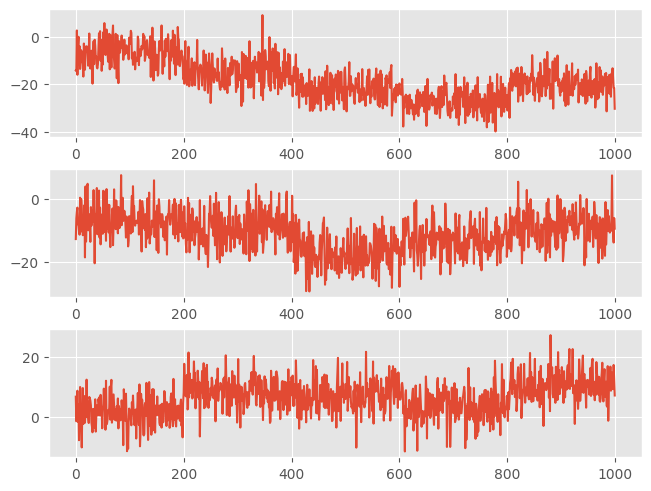

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, layout='constrained')

ax1.plot(x0,d1_signal_0)
ax2.plot(x1,d1_signal_1)
ax3.plot(x2,d1_signal_2)

* Synthetic datasets based on the project data's shape (without noise)

In [10]:
# Dataset 0

lists_d0 = []
for j in range(0,4501,500):
  lists_d0.append([i for i in range(j,j+500,20)])
for lista in lists_d0:
  lista.reverse()
lists_d0.reverse()

lists_d0_nr = []
for j in range(0,5001,500):
  lists_d0_nr.append(np.repeat(j,50).tolist())
lists_d0_nr.reverse()

final_list_d0 = []
for i in range(min(len(lists_d0),len(lists_d0_nr))):
  final_list_d0 = final_list_d0 + lists_d0_nr[i] + lists_d0[i]
final_list_d0 = final_list_d0 + lists_d0_nr[-1]

In [11]:
# Dataset 1

lists_d1 = []
for j in range(11):
  lists_d1.append([2000+5*i for i in range(51)])

lists_d1_r = []
for j in range(10):
  l = [2000+5*i for i in range(0,51,2)]
  l.reverse()
  lists_d1_r.append(l)
del l

final_list_d1 = []
for i in range(min(len(lists_d1),len(lists_d1_r))):
  final_list_d1 = final_list_d1 + lists_d1[i] + lists_d1_r[i]
final_list_d1 = final_list_d1 + lists_d1[-1]

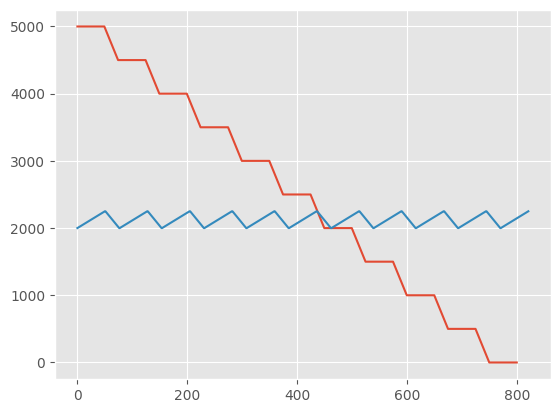

In [12]:
y_d0 = np.array(final_list_d0)
y_d1 = np.array(final_list_d1)
x_d0 = [i for i in range(len(y_d0))]
x_d1 = [i for i in range(len(y_d1))]
plt.plot(x_d0,y_d0)
plt.plot(x_d1,y_d1)

## 1. Algorithms

### 1.1 Piece wise linear-regression

In [15]:
def piece_wise_lr_cpd(data, columnName, peice_diff=100):

  st_idx, end_idx = 0, peice_diff
  coeff = []
  while end_idx<=data.shape[0]:

      X = [[x] for x in np.arange(peice_diff)]
      y = list(data.iloc[list(range(st_idx, end_idx, 1))][columnName])

      min_v, max_v = min(y), max(y)
      y = [(x-min_v)/(max_v-min_v) for x in y]

      model = LinearRegression()
      model.fit(X, y)

      coeff.extend([abs(model.coef_[0])]*peice_diff)
      #print(data.iloc[st_idx].index, data.iloc[end_idx].index, abs(model.coef_[0]))

      st_idx = end_idx
      end_idx = end_idx+peice_diff

  return coeff

* Signal

In [20]:
# dataframe creation
ts_df = pd.DataFrame(signal, columns=['series_1','series_2','series_3'])

# compute results
ts_df['coeff_1'] = piece_wise_lr_cpd(ts_df, 'series_1', peice_diff=200)
ts_df['coeff_2'] = piece_wise_lr_cpd(ts_df, 'series_2', peice_diff=200)
ts_df['coeff_3'] = piece_wise_lr_cpd(ts_df, 'series_3', peice_diff=200)

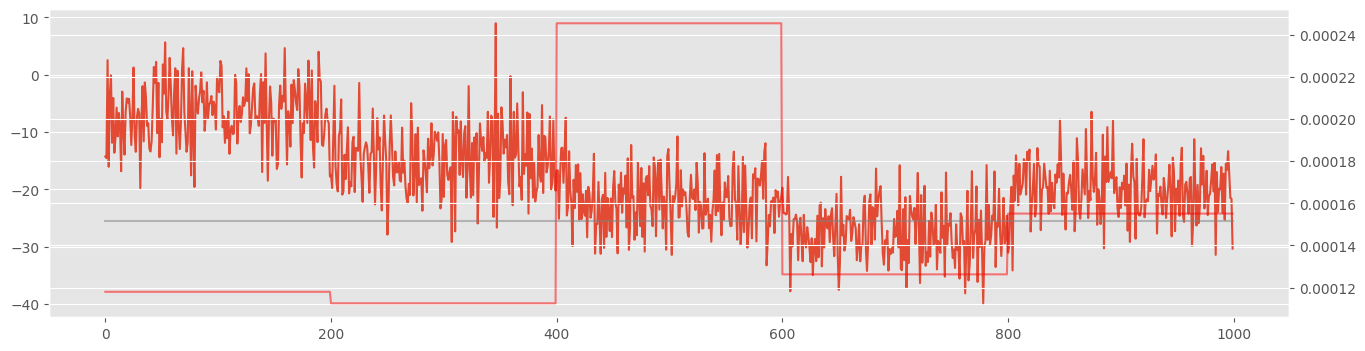

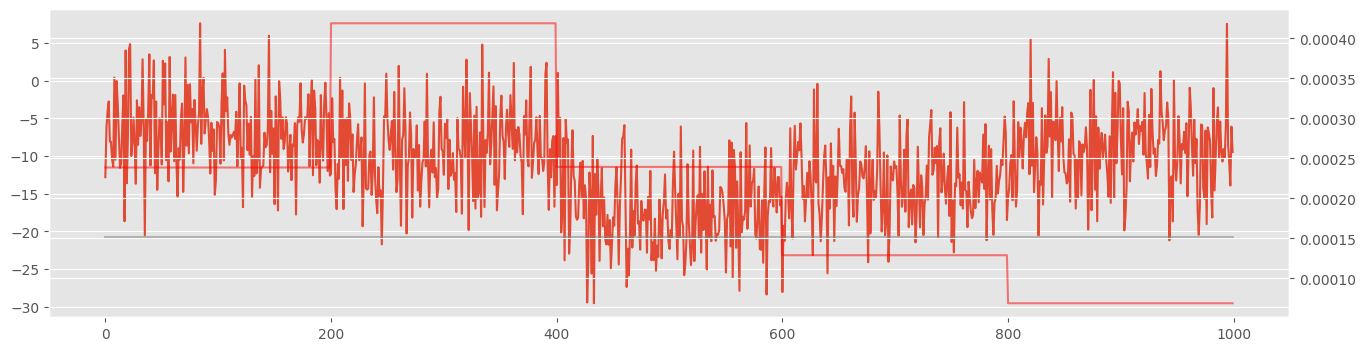

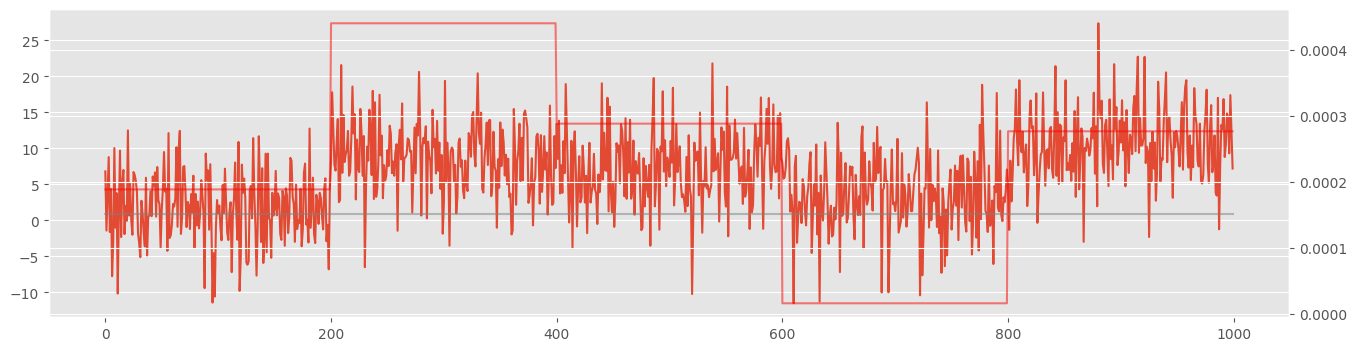

In [22]:
# plot the results
fig, ax1 = plt.subplots(figsize=(16,4))
ax2 = ax1.twinx()
ax1.plot(ts_df.index, ts_df.series_1)
ax2.plot(ts_df.index, ts_df.coeff_1, color='red', alpha=0.5)
ax2.plot(ts_df.index, [np.mean(ts_df.coeff_1)]*ts_df.shape[0], color='grey', alpha=0.5)
ax1.grid(axis='x')
plt.show()

# plot the results
fig, ax1 = plt.subplots(figsize=(16,4))
ax2 = ax1.twinx()
ax1.plot(ts_df.index, ts_df.series_2)
ax2.plot(ts_df.index, ts_df.coeff_2, color='red', alpha=0.5)
ax2.plot(ts_df.index, [np.mean(ts_df.coeff_1)]*ts_df.shape[0], color='grey', alpha=0.5)
ax1.grid(axis='x')
plt.show()

# plot the results
fig, ax1 = plt.subplots(figsize=(16,4))
ax2 = ax1.twinx()
ax1.plot(ts_df.index, ts_df.series_3)
ax2.plot(ts_df.index, ts_df.coeff_3, color='red', alpha=0.5)
ax2.plot(ts_df.index, [np.mean(ts_df.coeff_1)]*ts_df.shape[0], color='grey', alpha=0.5)
ax1.grid(axis='x')
plt.show()

This algorithm depends on the batch size, so it is discarded. We are not even going to test in the synthetic datasets.

### 1.2 Ruptures library

* Signal

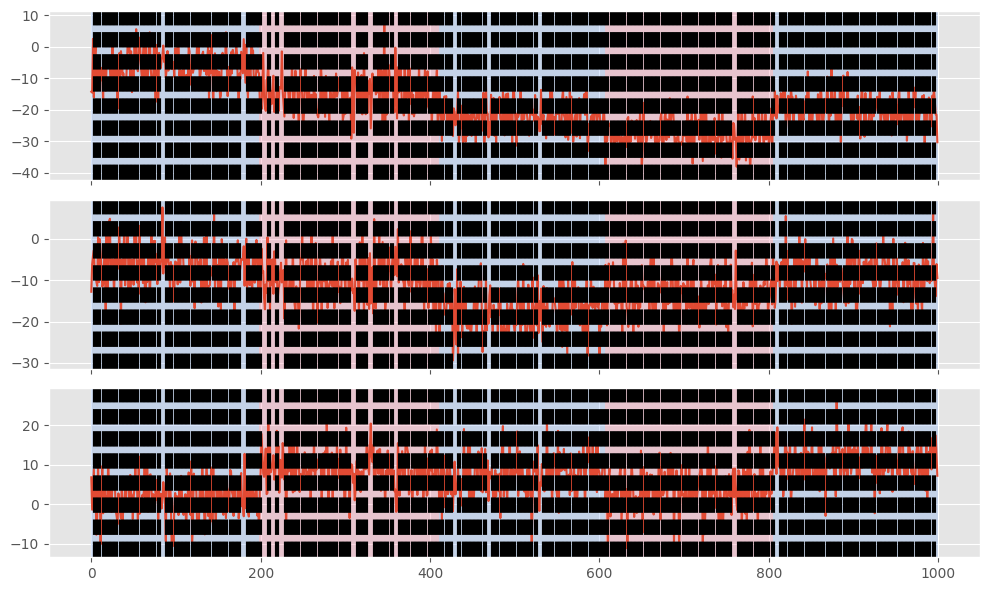

In [33]:
# detection
algo = rpt.Pelt(model="l2").fit(signal)
result = algo.predict(pen=10)

# display
rpt.display(signal, bkps, result)
plt.show()

* Synthetic datasets

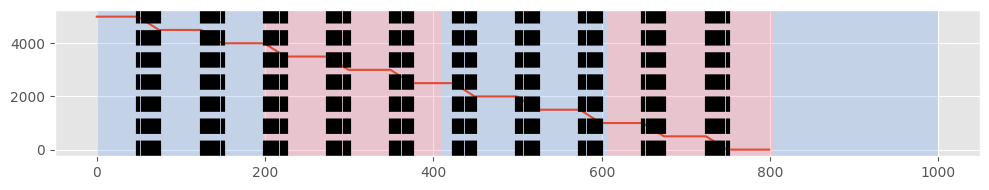

In [28]:
# fit
model = rpt.Pelt(model="l2")
model.fit(y_d0)
result = model.predict(pen=10)

# display
rpt.display(y_d0, bkps, result)
plt.show()

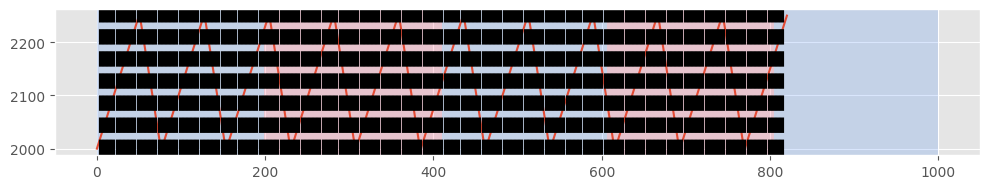

In [34]:
# fit
model = rpt.Pelt(model="l2")
model.fit(y_d1)
result = model.predict(pen=10)

# display
rpt.display(y_d1, bkps, result)
plt.show()

Let's take a look to the implementation in one changeing point interval with L2 cost.

In [35]:
# Least absolute derivation (L1)
def l1_cost(signal, start, end):
  subset = signal[start:end]
  med = np.median(subset, axis=0)
  return abs(subset - med).sum()

# Least squared deviation (L2)
def l2_cost(signal, start, end):
  subset = signal[start:end]
  return subset.var(axis=0).sum()*(end - start)

# function
def optimal_cp(signal, start, end):
        segment_cost = l2_cost(signal, start, end)
        if np.isinf(segment_cost) and segment_cost < 0:  # if cost is -inf
            return None, 0
        gain_list = list()
        for bkp in range(start, end, 5):
            if bkp - start >= 1 and end - bkp >= 1:
                gain = (
                    segment_cost - l2_cost(signal, start, bkp) - l2_cost(signal, bkp, end)
                )
                gain_list.append((gain, bkp))
        try:
            gain, bkp = max(gain_list)
        except ValueError:  # if empty sub_sampling
            return None, 0
        return gain_list, bkp, gain

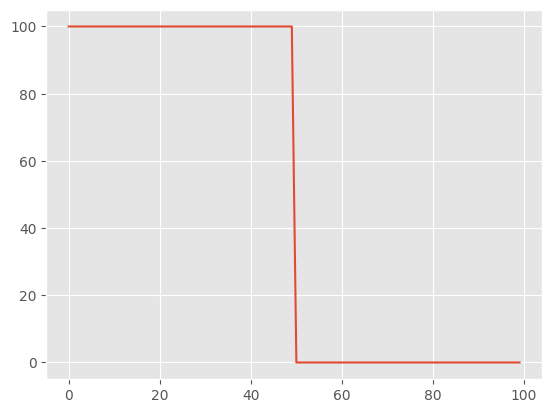

In [36]:
y_ = np.array(np.repeat(100,50).tolist() + np.repeat(0,50).tolist())
x_ = range(len(y_))

plt.plot(x_,y_)

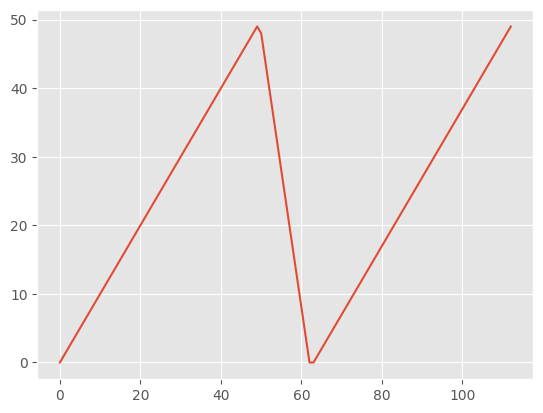

In [39]:
rev = [i for i in range(0,50,4)]
rev.reverse()
y__ = np.array([i for i in range(50)] + rev + [i for i in range(50)])
x__ = np.array([i for i in range(len(y__))])

plt.plot(x__,y__)

In [44]:
gain_list, bkp, gain = optimal_cp(y_, 0, len(y_)-1)
max(gain_list)

(247474.74747474756, 50)

In [43]:
gain_list, bkp, gain = optimal_cp(y__, 0, len(y__)-1)
max(gain_list)

(5277.952251552797, 20)

The first case works, because the changing point is in the 50th position. The second case does not work, there is no changing point in the 20th position. This is because L1 and L2 use the variance and standard deviation. In the second case it only would work with the monotony. It is probably that the autoregressive cost function will work.

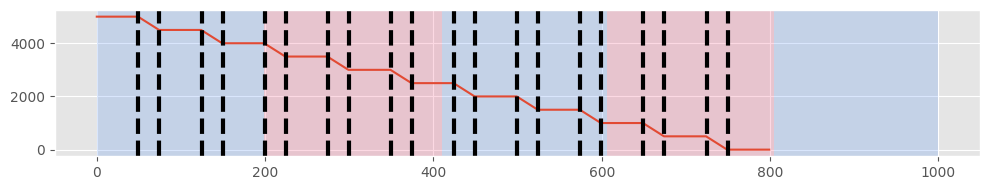

In [45]:
# fit
model = rpt.Pelt(model="ar")
model.fit(y_d0)
result = model.predict(pen=10)

# display
rpt.display(y_d0, bkps, result)
plt.show()

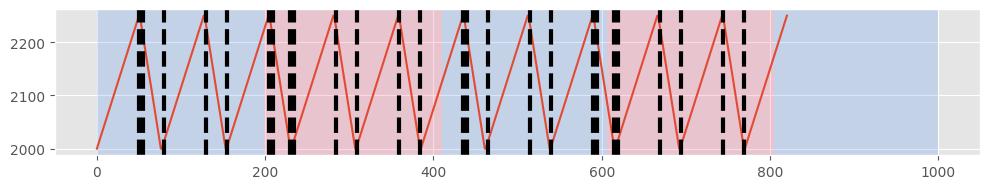

In [46]:
# fit
model = rpt.Pelt(model="ar")
model.fit(y_d1)
result = model.predict(pen=10)

# display
rpt.display(y_d1, bkps, result)
plt.show()

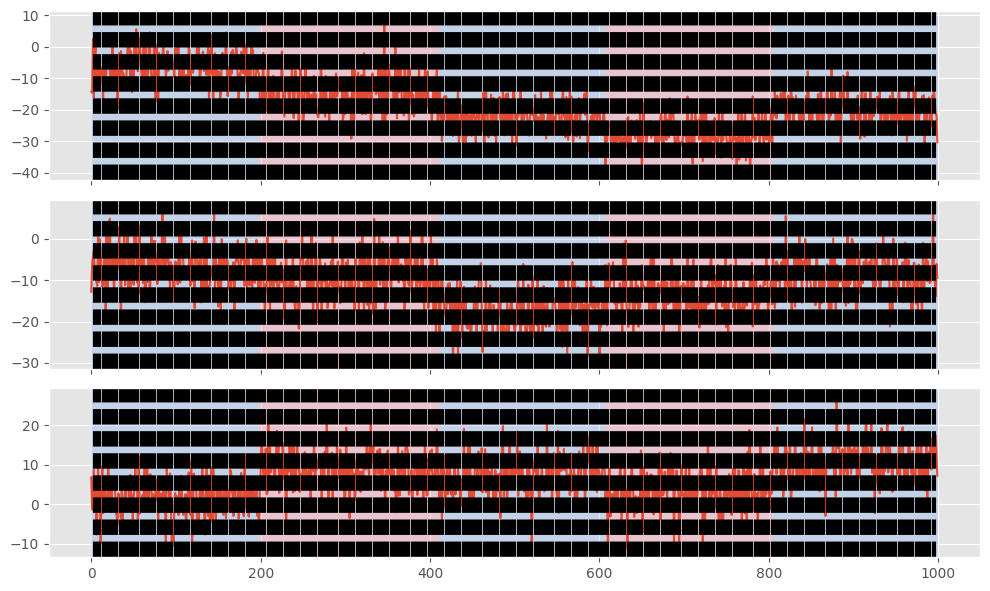

In [47]:
# detection
algo = rpt.Pelt(model="ar").fit(signal)
result = algo.predict(pen=10)

# display
rpt.display(signal, bkps, result)
plt.show()

It seems to do it. Now we have to implement it in PySpark and test in every cases to fit the tolerance.